# Self-Organized Criticality

### Imports 

In [1]:
%config Completer.use_jedi = False

import tqdm
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

import jplotlib as jpl

keras = tf.keras
tfkl = keras.layers
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

## Binary Network

Let $N=( \mathbf{a}, \mathbf{\bar{a}}, C )$ be a $n$-node network where
- $\mathbf{a} = a_{1,2,\dots,n} \in [0,1]^{b \times n}$ are its node states 
- $\mathbf{\bar{a}} = \bar{a}_{1,2,\dots,n} \in [0,1]^{b \times n}$ are its mean node states 
- $C = \{c_{ij}\} \in [-1, 1]^{n \times n}$ is its connectivity matrix from node $i$ to node $j$

At every time step:
- all nodes update their state by $\mathbf{a}' \sim P(\sigma(\mathbf{a}C))$
- update mean activations $\mathbf{\bar{a}}' = \alpha \mathbf{a} + (1 - \alpha) \mathbf{\bar{a}}$
- one node $j$ is uniformly selected for presynaptic connectivity $C_{:,j}$ update by:
    - if $\bar{a_j} > +1-\epsilon$, randomly make one input $k$ negative $C_{k,j} = -1$
    - if $\bar{a_j} < -1+\epsilon$, randomly make one input $k$ positive $C_{k,j} = +1$
    - otherwise, randomly remove one input $C_{?,j} = 0$

Parameters:
- $n =$ number neurons
- $b =$ batch size
- $\beta \in (0, \infty) =$ inverse temperature. Higher values decrease entropy. 
- $P =$ the Bernoilli distribution
- $\epsilon =$ update threshold
- $\alpha \in [0, 1] =$ mean activation update window

taken from [Self-organized criticality in neural networks from activity-based-rewiring](https://arxiv.org/abs/2009.1178)

### `update` function

In [66]:
p = params = dict(
    n=32,
    b=1,
    beta=2,
    epsilon=0.2,
    alpha=0.1)

def update(inputs):
    a, a_ave, C = inputs
    
    a = tfp.distributions.Bernoulli(logits=p['beta'] * (a @ C)).sample()
    a = tf.cast(a, tf.float32)
    
    a_ave = p['alpha'] * a + (1 - p['alpha']) * a_ave
    
    js = tf.random.uniform(shape=(p['b'],), minval=0, maxval=p['n'], dtype=tf.int32) # dest nodes
    ks = tf.random.uniform(shape=(p['b'],), minval=0, maxval=p['n'], dtype=tf.int32) # src nodes
    
    for b in tf.range(p['b']):
        j = js[b]
        k = ks[b]
        
        if a_ave[b, j] > +1 - p['epsilon']:
            C[k,j].assign(-1.0)
        elif a_ave[b, j] < p['epsilon']:
            C[k,j].assign(+1.0)
        else:
            C[k,j].assign(0.0)
    
    return (a, a_ave, C)

def loop(data, duration=1000):    
    for _ in tf.range(duration):
        data = update(data)
    return data

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


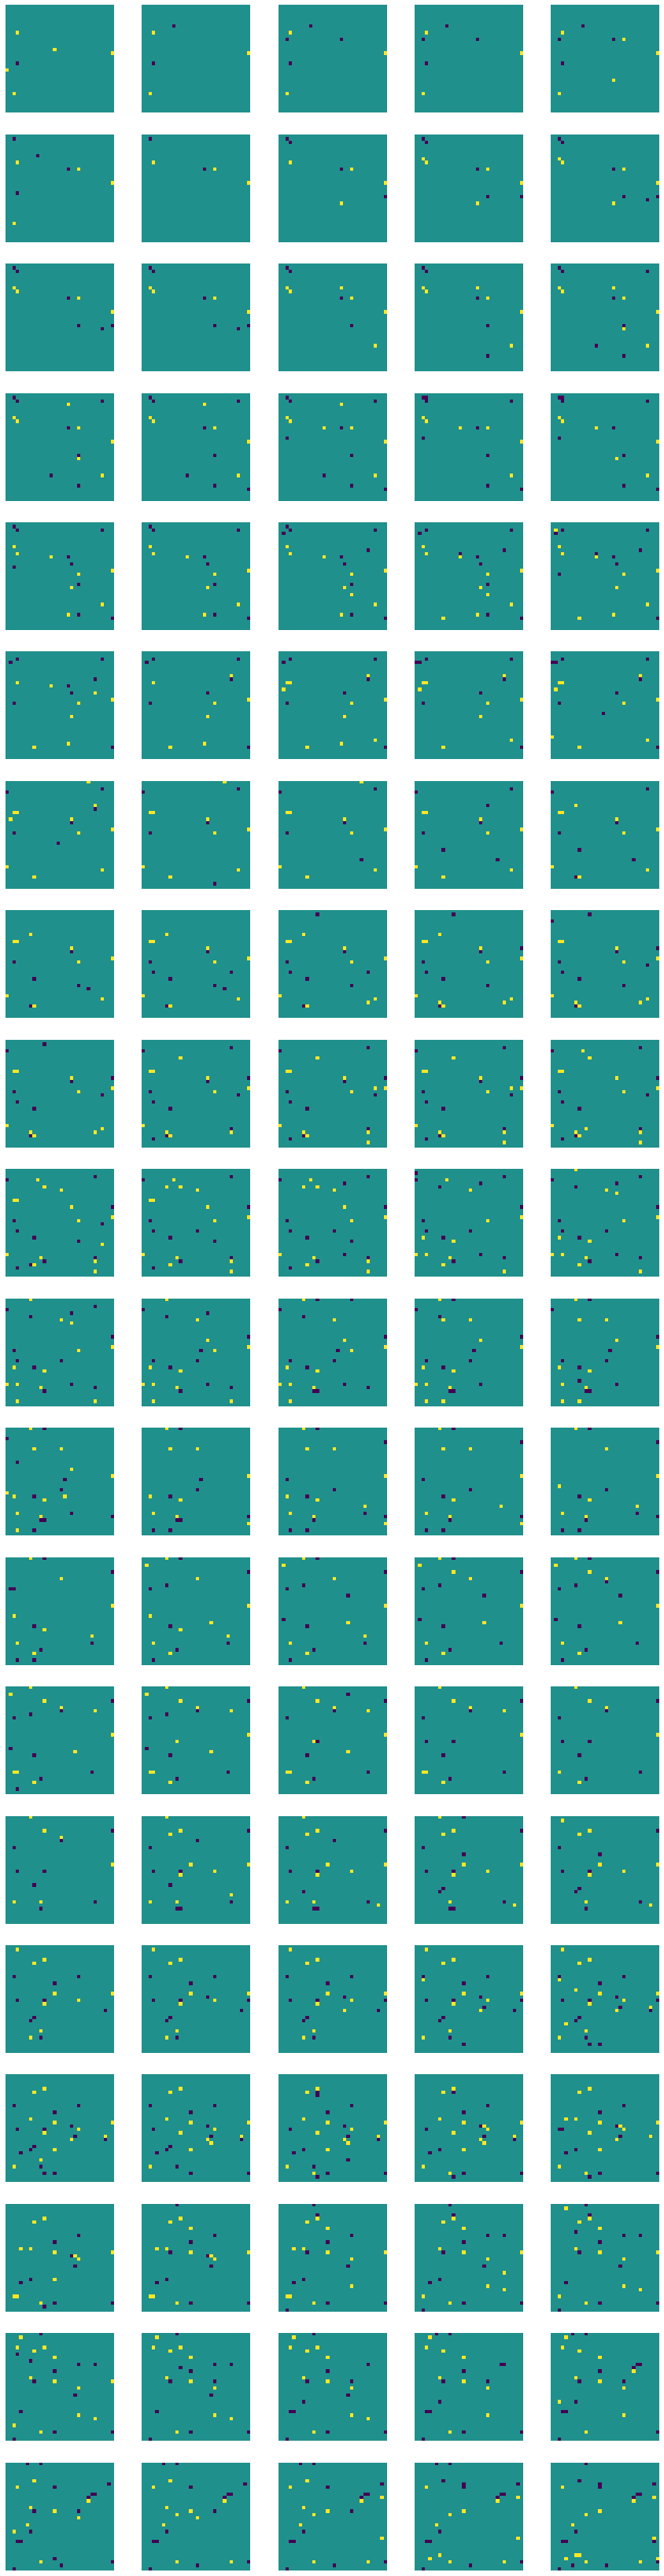

In [68]:
a = tf.zeros((params['b'], params['n']))
a_ave = tf.zeros((params['b'], params['n']))
C = tf.zeros((params['n'], params['n']))
#C = tf.random.uniform((params['n'], params['n']), minval=-1.0, maxval=1.0)
states = (a, a_ave, C)

T_step = 100
N = 100

N_col = 5
N_row = math.ceil(N / N_col)
fig, axes = plt.subplots(nrows=N_row, ncols=N_col, figsize=(3*N_col, 3*N_row))

for n in tqdm.tqdm(range(N)):
    a, a_ave, C = loop((a, a_ave, C), duration=T_step)
    
    col = n % N_col
    row = n // N_col
    axes[row, col].axis('off')
    axes[row, col].imshow(C)
        
plt.show()

100%|██████████| 100/100 [00:04<00:00, 22.29it/s]


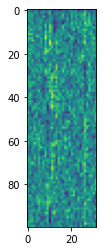

In [69]:
a = tf.zeros((params['b'], params['n']))
a_ave = tf.zeros((params['b'], params['n']))
C = tf.zeros((params['n'], params['n']))
#C = tf.random.uniform((params['n'], params['n']), minval=-1.0, maxval=1.0)
C = tf.Variable(C)
states = (a, a_ave, C)

T_step = 10
N = 100

N_col = 5
N_row = math.ceil(N / N_col)

a_aves = tf.Variable(tf.zeros((N, params['n'])))

for n in tqdm.tqdm(range(N)):
    a, a_ave, C = loop((a, a_ave, C), duration=T_step)
    a_aves[n].assign(tf.reduce_mean(a_ave, axis=0))
        
plt.imshow(a_aves)

### keras layer

In [33]:
class CriticalLayer0(tfkl.Layer):
    
    DEFAULT_PARAMS = dict(
        n=None,
        b=None,
        beta=2,
        epsilon=0.2,
        alpha=0.1,
        steps_update=10)
    
    def __init__(self, p=None, **kwargs):
        super(CriticalLayer0, self).__init__(**kwargs)
        
        if p is None:
            p = dict()
        self.p = CriticalLayer0.DEFAULT_PARAMS
        self.p.update(p)
        
    def build(self, input_shape):
        self.p['b'], self.p['n'] = input_shape.as_list()
        
        self.a_ave = tf.zeros((self.p['b'], self.p['n']), dtype=tf.float32)
        self.C = tf.random.uniform((self.p['n'], self.p['n']), dtype=tf.float32)
        self.C = tf.Variable(self.C)
        
    def call(self, inputs):
        a = inputs
        for _ in tf.range(self.p['steps_update']):
            a = self._single_update(a)
        return a

    def _single_update(self, a):
        a = self.p['beta'] * (a @ self.C)
        a = tfd.Bernoulli(logits=a).sample()
        a = tf.cast(a, tf.float32)

        self.a_ave = self.p['alpha'] * a + (1 - self.p['alpha']) * self.a_ave

        js = tf.random.uniform(shape=(self.p['b'],), 
                               minval=0, maxval=self.p['n'], 
                               dtype=tf.int32) # dest nodes
        ks = tf.random.uniform(shape=(self.p['b'],), 
                               minval=0, maxval=self.p['n'], 
                               dtype=tf.int32) # src nodes

        for b in tf.range(self.p['b']):
            j = js[b]
            k = ks[b]

            if self.a_ave[b, j] > +1 - self.p['epsilon']:
                self.C[k,j].assign(-1.0)
            elif self.a_ave[b, j] < self.p['epsilon']:
                self.C[k,j].assign(+1.0)
            else:
                self.C[k,j].assign(0.0)

        return a


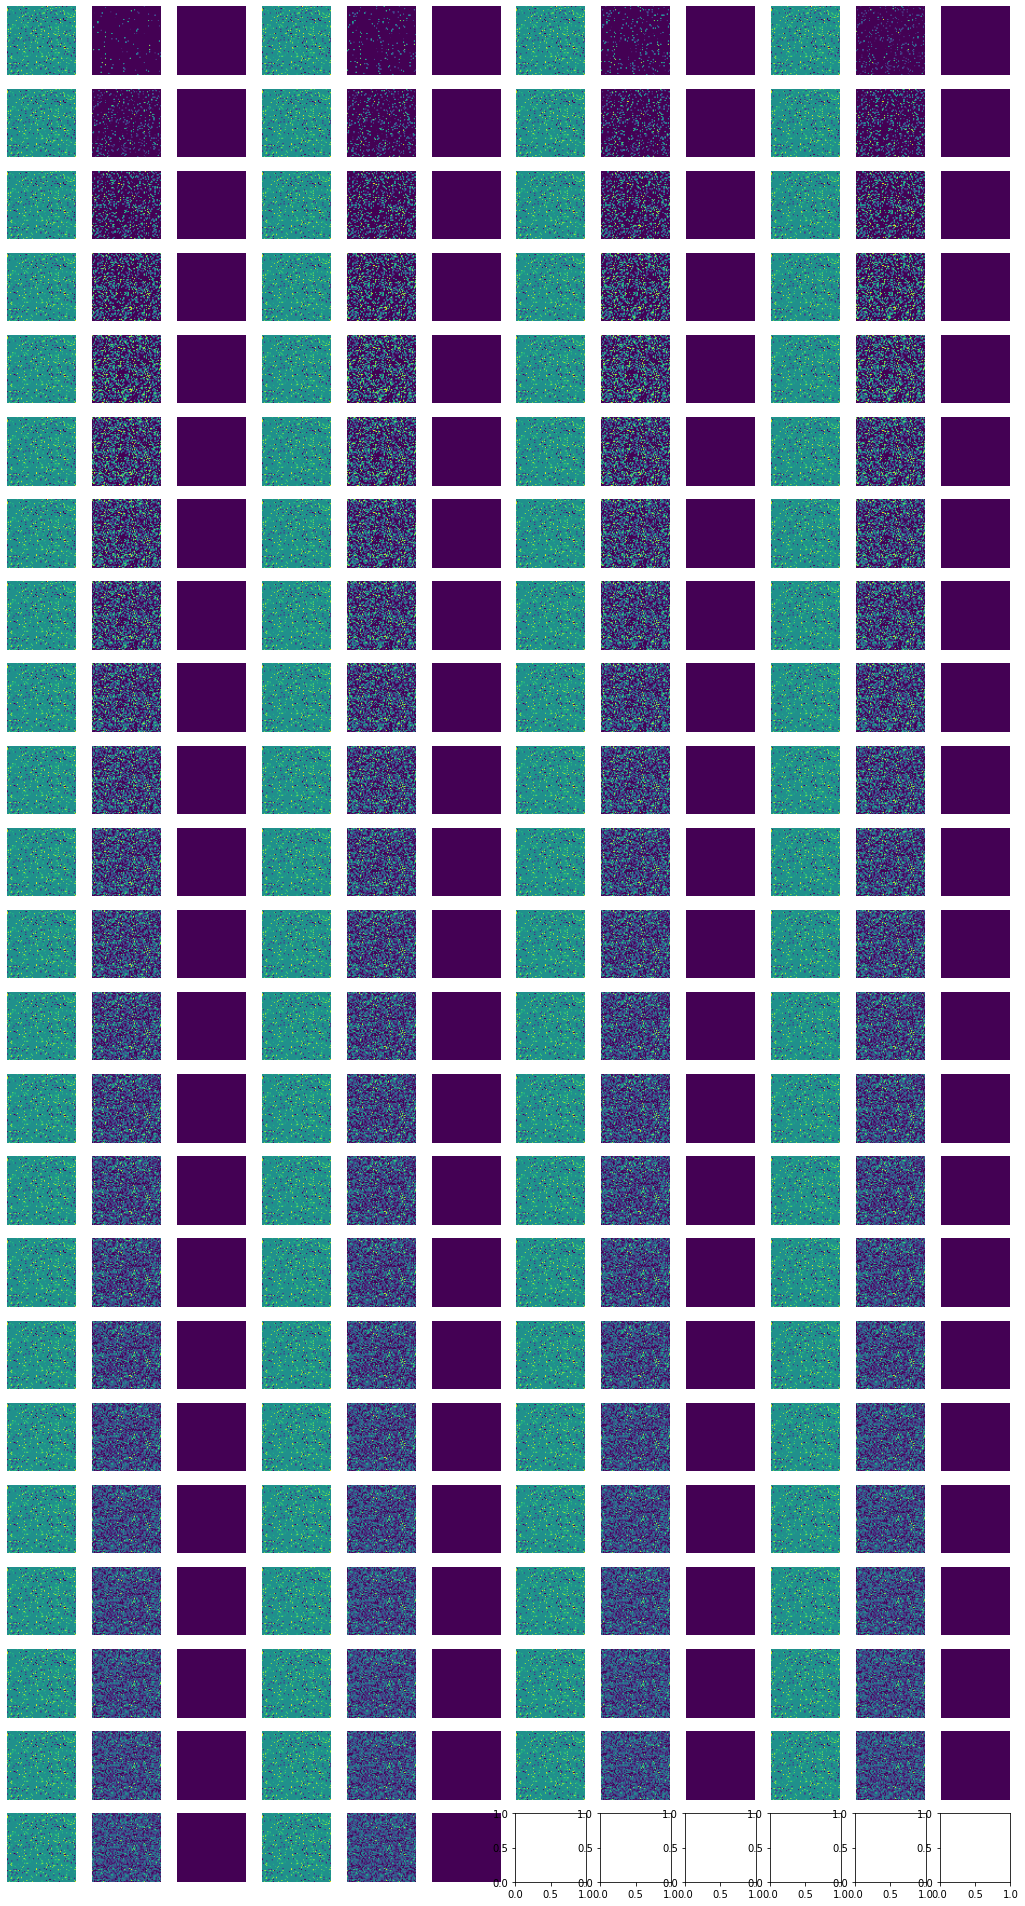

In [37]:
layer = CriticalLayer0(dict(
        beta=0.5,
        epsilon=0.1,
        alpha=0.005,
        steps_update=100))
a = tf.zeros((1, 64))

a = layer(a)
C_orig = layer.C.numpy()

with jpl.GridPlot(ncols=12, width=18) as grid_plot:
    for _ in range(90):
        a = layer(a)
        
        grid_plot.imshow(layer.C)
        C_diff = C_orig - layer.C
        grid_plot.imshow(tf.nn.relu(C_diff))
        grid_plot.imshow(tf.nn.relu(-C_diff))